# SIECI NEURONOWE - Ćwiczenie 4

W ćwiczeniu 4 odtworzymy zaimplementowaną już architekturę sieci w pełni połączonej korzystając z gotowego rozwiązania do budowania sieci neuronowych. Poniżej jest podany jest przykład uczenia w Pytorchu, inne rozwiązania są dopuszczalne (tensorflow, w jego obrębie keras który jest nawet prostszy), pod warunkiem że dopuszczają zdefiniowanie własnej architektury sieci.

Od frameworku do głębokiego uczenia oczekujemy w pierwszej kolejności:
- Implementacji operacji macierzowych/tensorowych w takim zakresie jakie będą nam potrzebne do budowy sieci
- Możliwości automatycznego wyliczania gradientów po zaimplementowanych operacjach
- Wydajnej implementacji dedykowanej GPU/TPU Oraz typowych funkcjonalności ułatwiających budowanie sieci neuronowych z wykorzystaniem powyższych (funkcje kosztu, standardowe warstwy, optimizery itp.).

Dla torcha, konwencja jest następująca: korzystamy z obiektów torch.tensor do przechowywania danych, natomiast sieć zbudowana jest z modułów dziedziczących po torch.NN.module. Przez tensor rozumiemy tutaj n-wymiarową tablicę liczb analogicznie do numpy. Dla tensorów nadpisane są podstawowe operatory matematyczne, dostępne są operacje na tablicach podobne do dostępnych w numpy (zmiany kształtu, transpozycje, agregacje takiej jak średnia i suma etc.). W obiekcie tensora obok właściwej wartości może być zapisany również gradient. Gradient, jeżeli istnieje, zawsze będzie tensorem o tym samym wymiarze co właściwe dane tensora. Jest inicjalizowany przy pierwszym przejściu propagacji wstecz przez dany tensor.

Model powinien dziedziczyć po torch.NN.module i definiować __init__() – operacje wykonywane przy tworzeniu instancji klasy oraz forward() – funkcję która na podstawie danych wejściowych zwraca wyjście modelu.

Oficjalny tutorial odnośnie tego, jak uczyć model, opisuje pętlę uczącą w ten sposób:
https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #1

def train_one_epoch(epoch_index, tb_writer):

    running_loss = 0.

    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch

    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):

        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad() #2

        # Make predictions for this batch
        outputs = model(inputs) #3

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels) #4
        loss.backward() #5

        # Adjust learning weights
        optimizer.step() #6

    return loss

Jak i dlaczego to działa?

1. Obiekt optimizer służy do optymalizowania danego zbioru parametrów. Parametry są podklasą tensora specjalnie uwzględnianymi przez moduły. 

parameters() dowolnego obiektu torch.NN.module zwraca parametry przynależące do tejże klasy oraz parametry każdej zmiennej przynależącej, która sama jest podklasą torch.NN.module. Uwaga: funkcja nie zadziała na zmiennych zagnieżdżonych jeśli jakikolwiek poziom nie jest podklasą torch.NN.module! Na przykład kod:
__init__(self):
    super(TinyModel, self).__init__()
    self.layer_list = [torch.nn.Linear(10,10) for i in range(123)] 
    
Stworzy listę 123 warstw liniowych 10x10, ale jako że jedyną zmienną przynależącą do klasy jest sama lista, model nie będzie poprawnie uwzględniał tych 123 warstw i ich macierzy wag w parameters().

2. zero_grad() jest potrzebne, ponieważ moduł automatycznego różniczkowania akumuluje, a nie nadpisuje gradienty przy wielokrotnym wywołaniu.

3. Wywołanie instancji modelu jak funkcji (pythonowe __call__) jest równoważne forward()

4. Funkcje kosztu są dostępne jako parametryzowalne klasy w torch.nn. To znaczy, że najpierw instancjonujemy je jako obiekt, a potem wywołujemy loss_fn() na odpowiednich tensorach odpowiadających wejściom i pożądanym wyjściom – należy zwrócić uwagę na oczekiwany typ tensora w dokumentacji i pamiętać o domyślnych formatach! (W szczególności, domyślny float torcha NIE zgadza się z domyślnym w numpy – 32 vs 64bit!)

5. backward() to całe przejście wstecz w algorytmie propagacji wstecznej. Jak udało się to tak uprościć? Po pierwsze, każda operacja na tensorach dostępna w torchu, analogicznie do sposobu implementacji sugerowanego w poprzednim ćwiczeniu, ma zarówno funkcję forward(), jak i backward(). Po drugie, operacje w trakcie przechodzenia w przód są dołączane do grafu obliczeniowego zawierającego informacje o tym skąd wejście do danej operacji. Istnienie grafu obliczeniowego pozwala przeiterować po wcześniej wywołanych operacjach wstecz i wyliczyć gradienty na każdym poziomie, oraz zakumulować je w obiektach parametrów.

6. step() dokonuje zmiany parametrów zgodnie z wartością gradientu i przyjętą regułą uczenia. Dla SGD jest to klasyczne -learning_rate*gradient

W ćwiczeniu należy zbudować sieć o tych samych parametrach co w zadaniu poprzednim, i ocenić jej działanie na tych samych danych, tym razem sprawdzając wpływ:
- wybranego optimizera (SGD i dwa inne)
- rozmiaru batcha
- wartości współczynnika uczenia dla różnych optimizerów

Ćwiczenie oceniane jest w skali 0-10 pkt.

## Rozwiązanie Zadania

Loaded X shape (303, 13), y shape (303,), device=cpu

=== Running: optimizer=SGD, batch=16, lr=0.1 ===
ep 01: train_loss=0.6610 val_loss=0.5531 val_acc=0.8163 val_auc=0.8653
ep 10: train_loss=0.3272 val_loss=0.4107 val_acc=0.8367 val_auc=0.9007
ep 20: train_loss=0.3018 val_loss=0.5821 val_acc=0.8163 val_auc=0.8855
ep 30: train_loss=0.5319 val_loss=0.4468 val_acc=0.7755 val_auc=0.8535
ep 40: train_loss=0.4333 val_loss=0.5260 val_acc=0.6939 val_auc=0.7879
ep 50: train_loss=0.4432 val_loss=0.5552 val_acc=0.7959 val_auc=0.8519
ep 60: train_loss=0.5303 val_loss=0.7032 val_acc=0.6939 val_auc=0.7508
ep 70: train_loss=0.3596 val_loss=0.5196 val_acc=0.7959 val_auc=0.8990
ep 80: train_loss=0.3687 val_loss=0.7181 val_acc=0.7959 val_auc=0.8586
ep 90: train_loss=0.2953 val_loss=0.9380 val_acc=0.7551 val_auc=0.8519
ep 100: train_loss=0.3339 val_loss=0.8757 val_acc=0.7551 val_auc=0.7795
ep 110: train_loss=0.3249 val_loss=0.8356 val_acc=0.7551 val_auc=0.8157
ep 120: train_loss=0.2491 val_loss=1.0476 v

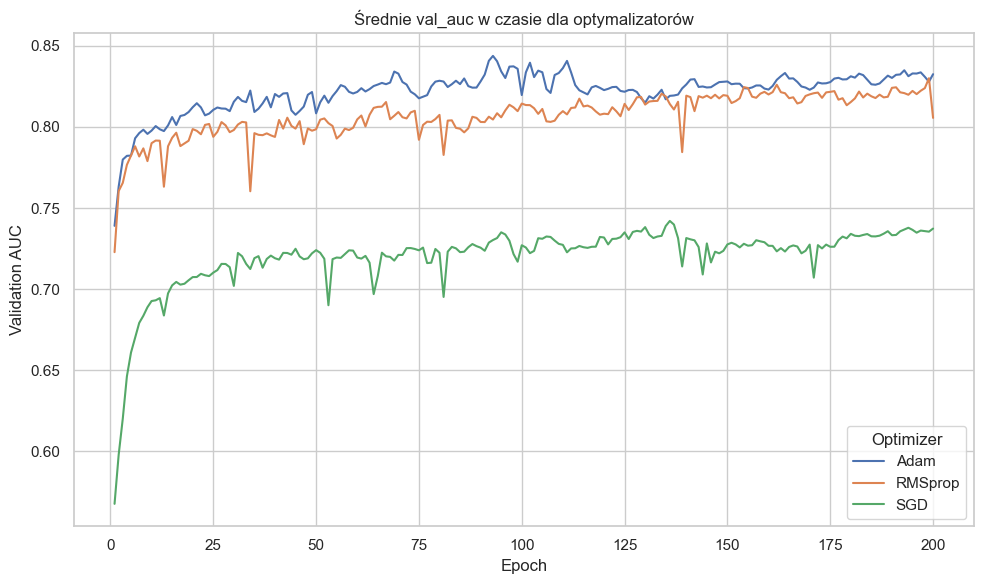

Saved plot: plots/val_auc_Adam.png


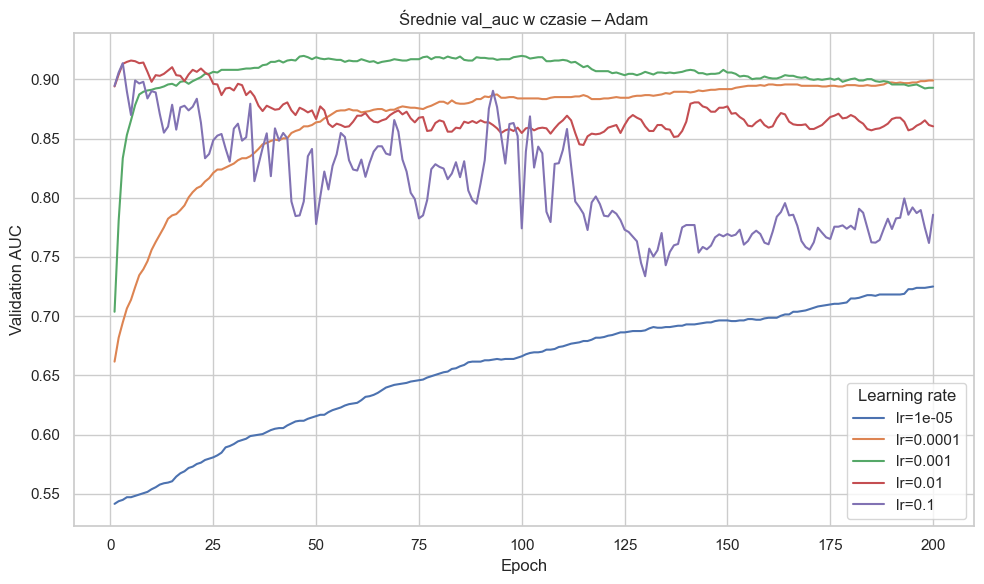

Saved plot: plots/val_auc_RMSprop.png


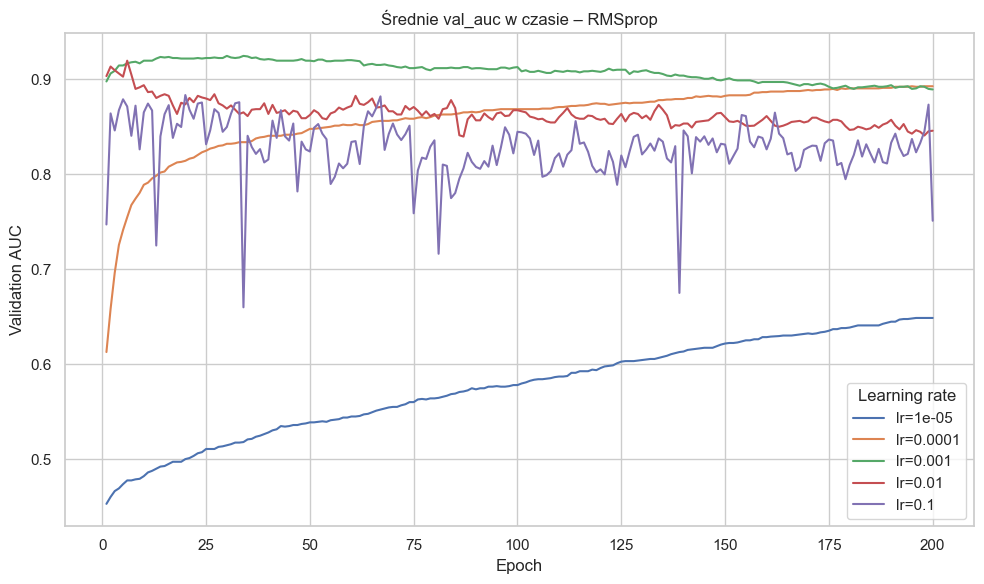

Saved plot: plots/val_auc_SGD.png


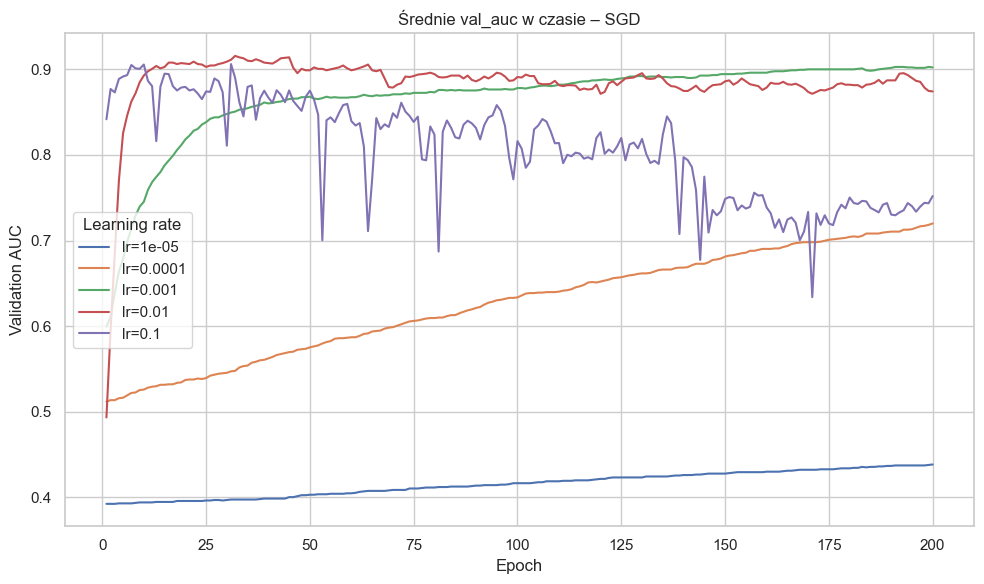

Saved plot: plots/val_auc_batch_Adam.png


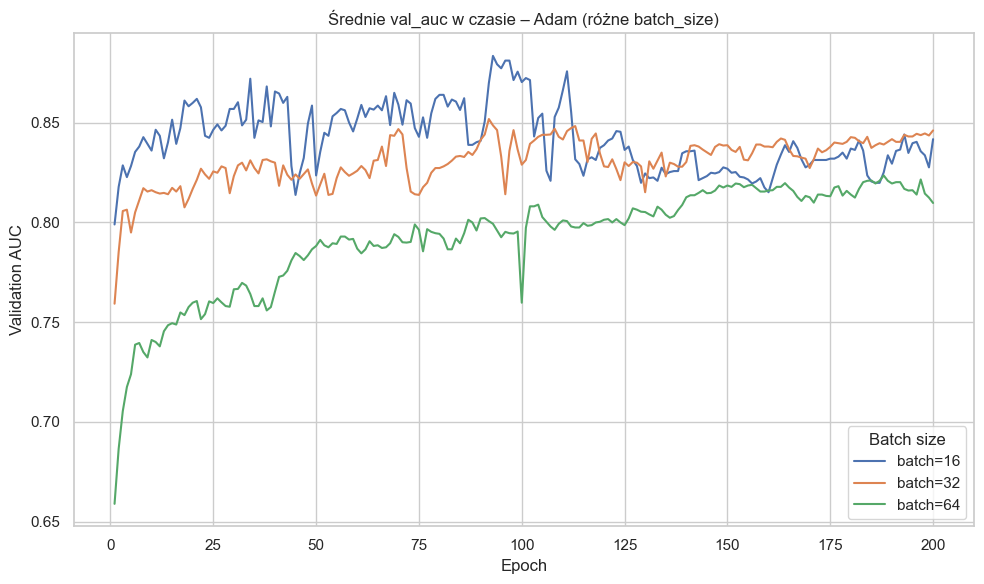

Saved plot: plots/val_auc_batch_RMSprop.png


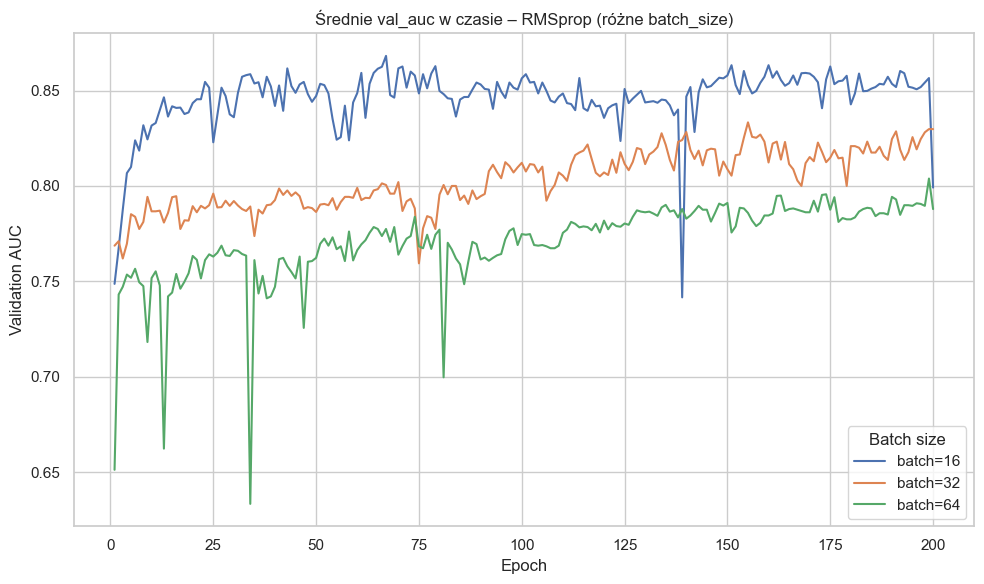

Saved plot: plots/val_auc_batch_SGD.png


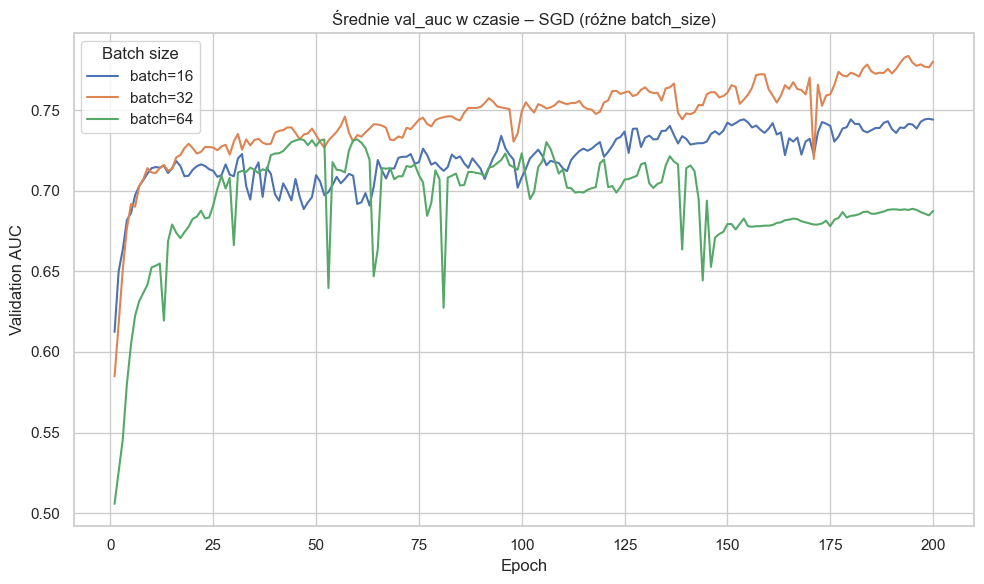

In [ ]:
"""
train_heart_experiments.py

Założenia:
- DATA_PATH = '../heart-disease/processed.cleveland.data'
- COLUMN_NAMES zgodne z treścią zadania
- Binary classification: target = (num > 0)
- Eksperymenty: optymalizery = [SGD, Adam, RMSprop], kilka batch_size i lr
- Wyniki zapisywane do results.csv
"""

import os
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

# CONFIG

DATA_PATH = '../heart-disease/processed.cleveland.data'
COLUMN_NAMES = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

SEED = 42

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if device.type == 'cuda':
    torch.cuda.manual_seed_all(SEED)

PLOTS_DIR = 'plots'
os.makedirs(PLOTS_DIR, exist_ok=True)
RESULTS_DIR = 'lab-4-results'
os.makedirs(RESULTS_DIR, exist_ok=True)
RESULTS_CSV = 'results_heart_experiments.csv'


# Hyperparam grid
optimizers_to_try = ['SGD', 'Adam', 'RMSprop']
batch_sizes = [16, 32, 64]
lrs = {
    'SGD':     [0.1, 0.01, 0.001, 0.0001, 0.00001],
    'Adam':    [0.1, 0.01, 0.001, 0.0001, 0.00001],
    'RMSprop': [0.1, 0.01, 0.001, 0.0001, 0.00001]
}
epochs = 200
weight_decay = 1e-4


# DATA LOADING & PREPROCESS

def load_and_preprocess(path):
    df = pd.read_csv(path, header=None, names=COLUMN_NAMES, na_values='?')
    df = df.dropna(how='all')

    for col in df.columns:
        if df[col].isnull().any():
            df[col] = df[col].fillna(df[col].median())

    df['target'] = (df['num'] > 0).astype(int)
    X = df.drop(columns=['num', 'target']).values.astype(np.float32)
    y = df['target'].values.astype(np.int64)
    return X, y, df

X, y, df = load_and_preprocess(DATA_PATH)
print(f"Loaded X shape {X.shape}, y shape {y.shape}, device={device}")

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=SEED, stratify=y_temp)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val   = scaler.transform(X_val)
X_test  = scaler.transform(X_test)

def get_loaders(batch_size):
    train_ds = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
    val_ds   = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
    test_ds  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader


# MODEL (fully-connected)

class NeuralNetwork(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims=[32,16], dropout=0.2):
        super().__init__()

        layers = []
        last = input_dim

        for h in hidden_dims:
            layers.append(nn.Linear(last, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            last = h

        layers.append(nn.Linear(last, 1))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x).squeeze(1) 


# TRAIN / EVAL helpers

def get_optimizer(name, params, lr):
    if name == 'SGD':
        return torch.optim.SGD(params, lr=lr, momentum=0.9, weight_decay=weight_decay)
    elif name == 'Adam':
        return torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)
    elif name == 'RMSprop':
        return torch.optim.RMSprop(params, lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError(name)

bce_loss = nn.BCEWithLogitsLoss()

def train_one_epoch(model, loader, optimizer):
    model.train()
    
    running_loss = 0.0
    
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.float().to(device)
    
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = bce_loss(outputs, labels)
    
        loss.backward()
        optimizer.step()
    
        running_loss += loss.item() * inputs.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    
    all_logits = []
    all_labels = []
    
    total_loss = 0.0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.float().to(device)
            
            logits = model(inputs)
            loss = bce_loss(logits, labels)
            total_loss += loss.item() * inputs.size(0)
            
            all_logits.append(logits)
            all_labels.append(labels)
    
    logits = torch.cat(all_logits)
    labels = torch.cat(all_labels)
    
    probs = torch.sigmoid(logits)
    
    acc = ((probs >= 0.5) == labels).float().mean().item()
    
    try:
        auc = roc_auc_score(labels.cpu().numpy(), probs.cpu().numpy())
    except Exception:
        auc = float('nan')
    
    return total_loss / len(loader.dataset), acc, auc


# EXPERIMENT GRID

results_summary = []
results_detailed = []

for opt_name in optimizers_to_try:
    for batch_size in batch_sizes:
        train_loader, val_loader, test_loader = get_loaders(batch_size)
        for lr in lrs[opt_name]:
            print(f"\n=== Running: optimizer={opt_name}, batch={batch_size}, lr={lr} ===")
            model = NeuralNetwork(input_dim=X_train.shape[1], hidden_dims=[32, 16], dropout=0.2).to(device)
            optimizer = get_optimizer(opt_name, model.parameters(), lr)
            best_val_auc = -1.0
            history = {'train_loss': [], 'val_loss': [], 'val_acc': [], 'val_auc': []}

            for ep in range(1, epochs + 1):
                train_loss = train_one_epoch(model, train_loader, optimizer)
                val_loss, val_acc, val_auc = evaluate(model, val_loader)

                history['train_loss'].append(train_loss)
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                history['val_auc'].append(val_auc)

                results_detailed.append({
                    'optimizer': opt_name,
                    'batch_size': batch_size,
                    'lr': lr,
                    'epoch': ep,
                    'train_loss': train_loss,
                    'val_loss': val_loss,
                    'val_acc': val_acc,
                    'val_auc': val_auc
                })

                if ep % 10 == 0 or ep == 1:
                    print(f"ep {ep:02d}: train_loss={train_loss:.4f} val_loss={val_loss:.4f} "
                          f"val_acc={val_acc:.4f} val_auc={val_auc:.4f}")

                if val_auc > best_val_auc:
                    best_val_auc = val_auc
                    best_state = {k: v.cpu() for k, v in model.state_dict().items()}

            model.load_state_dict({k: v.to(device) for k, v in best_state.items()})
            test_loss, test_acc, test_auc = evaluate(model, test_loader)
            print(f"--> test_acc={test_acc:.4f}, test_auc={test_auc:.4f}")

            results_summary.append({
                'optimizer': opt_name,
                'batch_size': batch_size,
                'lr': lr,
                'test_loss': test_loss,
                'test_acc': test_acc,
                'test_auc': test_auc,
                'best_val_auc': best_val_auc
            })


# ZAPIS WYNIKÓW

summary_path = os.path.join(RESULTS_DIR, 'results_summary.csv')
detailed_path = os.path.join(RESULTS_DIR, 'results_detailed.csv')

pd.DataFrame(results_summary).to_csv(summary_path, index=False)
pd.DataFrame(results_detailed).to_csv(detailed_path, index=False)

print(f"\nAll experiments finished.")
print(f"Summary saved to {summary_path}")
print(f"Full epoch logs saved to {detailed_path}")


# ZBIORCZY WYKRES VAL AUC 

import seaborn as sns

df_detailed = pd.DataFrame(results_detailed)

plt.figure(figsize=(10,6))
sns.set(style="whitegrid")

for opt_name, group in df_detailed.groupby('optimizer'):
    auc_mean = group.groupby('epoch')['val_auc'].mean()
    plt.plot(auc_mean.index, auc_mean.values, label=opt_name)

plt.title("Średnie val_auc w czasie dla optymalizatorów")
plt.xlabel("Epoch")
plt.ylabel("Validation AUC")
plt.legend(title="Optimizer")
plt.tight_layout()
plt.show()


# WYKRESY: val_auc vs epoch dla różnych lr w obrębie każdego optymalizatora

for opt_name, group in df_detailed.groupby('optimizer'):
    plt.figure(figsize=(10,6))
    sns.set(style="whitegrid")

    for lr_val, lr_group in group.groupby('lr'):
        auc_mean = lr_group.groupby('epoch')['val_auc'].mean()
        plt.plot(auc_mean.index, auc_mean.values, label=f"lr={lr_val}")

    plt.title(f"Średnie val_auc w czasie – {opt_name}")
    plt.xlabel("Epoch")
    plt.ylabel("Validation AUC")
    plt.legend(title="Learning rate")
    plt.tight_layout()

    save_path = os.path.join(PLOTS_DIR, f"val_auc_{opt_name}.png")
    plt.savefig(save_path)
    print(f"Saved plot: {save_path}")
    plt.show()

# WYKRESY: val_auc vs epoch dla różnych batch_size (dla każdego optymalizatora)

for opt_name, group in df_detailed.groupby('optimizer'):
    plt.figure(figsize=(10,6))
    sns.set(style="whitegrid")

    for batch_val, batch_group in group.groupby('batch_size'):
        auc_mean = batch_group.groupby('epoch')['val_auc'].mean()
        plt.plot(auc_mean.index, auc_mean.values, label=f"batch={batch_val}")

    plt.title(f"Średnie val_auc w czasie – {opt_name} (różne batch_size)")
    plt.xlabel("Epoch")
    plt.ylabel("Validation AUC")
    plt.legend(title="Batch size")
    plt.tight_layout()

    save_path = os.path.join(PLOTS_DIR, f"val_auc_batch_{opt_name}.png")
    plt.savefig(save_path)
    print(f"Saved plot: {save_path}")
    plt.show()